## Programación del filtro de Kalman

#### Creamos la clase Kalman

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

class Kalman:
    def __init__(self, transition_covariance=0.01, observation_covariance=[0.1, 10]):
        """
        Inicializa el filtro de Kalman para un LOB.

        Parámetros:
        - transition_covariance: Covarianza del ruido del proceso (Q).
        - observation_covariance: Covarianza del ruido de observación (R).
        """
        self.transition_covariance = transition_covariance
        self.observation_covariance = np.diag(observation_covariance)

        # Matriz de transición (4x4)
        self.transition_matrix = np.array([
            [1, 1, 0, 0],  # p_t = p_{t-1} + v_{t-1}
            [0, 1, 0, 0],  # v_t = v_{t-1}
            [0, 0, 1, 1],  # d_t = d_{t-1} + s_{t-1}
            [0, 0, 0, 1]   # s_t = s_{t-1}
        ])

        # Matriz de observación (2x4)
        self.observation_matrix = np.array([
            [1, 0, 0, 0],  # Observamos p_t
            [0, 0, 1, 0]   # Observamos d_t
        ])

    def fit(self, mid_price, volume_diff):
        """
        Ajusta el filtro de Kalman a los datos del LOB.

        Parámetros:
        - mid_price: Serie temporal del mid price.
        - volume_diff: Serie temporal de la diferencia de volúmenes (bid - ask).
        """
        # Estado inicial
        initial_state_mean = [mid_price.iloc[0], 0, volume_diff.iloc[0], 0]
        initial_state_covariance = np.eye(4)

        # Crear el filtro
        self.kf = KalmanFilter(
            transition_matrices=self.transition_matrix,
            observation_matrices=self.observation_matrix,
            initial_state_mean=initial_state_mean,
            initial_state_covariance=initial_state_covariance,
            transition_covariance=self.transition_covariance * np.eye(4),
            observation_covariance=self.observation_covariance
        )

        # Datos de observación
        observations = np.column_stack([mid_price, volume_diff])

        # Filtrar
        self.states, _ = self.kf.filter(observations)

        return self.states

    def plot_results(self, df):
        """
        Grafica los resultados del filtro de Kalman.

        Parámetros:
        - df: DataFrame con los datos del LOB (debe incluir 'mid_price', 'best_bid', 'best_ask', 'volume_diff').
        """
        df['estimated_price'] = self.states[:, 0]
        df['estimated_trend'] = self.states[:, 1]
        df['estimated_volume_diff'] = self.states[:, 2]
        df['estimated_volume_trend'] = self.states[:, 3]

        plt.figure(figsize=(14, 10))

        # Gráfica del precio
        plt.subplot(2, 1, 1)
        plt.plot(df['mid_price'], label='Mid Price Observado', alpha=0.5, color='gray')
        plt.plot(df['best_bid'], label='Best Bid', alpha=0.7, color='green')
        plt.plot(df['best_ask'], label='Best Ask', alpha=0.7, color='red')
        plt.plot(df['estimated_price'], label='Precio Estimado (Kalman)', linewidth=2, color='blue')
        plt.legend()
        plt.title('Precio, Best Bid/Ask y Tendencia Estimados')

        # Gráfica de la diferencia de volúmenes
        plt.subplot(2, 1, 2)
        plt.plot(df['volume_diff'], label='Diferencia de Volúmenes Observada', alpha=0.5, color='purple')
        plt.plot(df['estimated_volume_diff'], label='Diferencia de Volúmenes Estimada (Kalman)', linewidth=2, color='orange')
        plt.legend()
        plt.title('Presión de Compra/Venta y Tendencia')

        plt.tight_layout()
        plt.show()


#### Generamos unos datos simulados

In [2]:
# Datos simulados del LOB
np.random.seed(42)
n = 100  # Número de observaciones
true_price = np.cumsum(np.random.normal(0, 0.5, n)) + 100  # Precio real
mid_price = true_price + np.random.normal(0, 0.3, n)     # Mid-price observado
spread = 0.5  # Spread típico
best_bid = mid_price - spread / 2  # Precio bid
best_ask = mid_price + spread / 2  # Precio ask
bid_volume = np.random.poisson(50, n)  # Volumen bid
ask_volume = np.random.poisson(50, n)  # Volumen ask
volume_diff = bid_volume - ask_volume  # Diferencia de volúmenes

# DataFrame
df = pd.DataFrame({
    'mid_price': mid_price,
    'best_bid': best_bid,
    'best_ask': best_ask,
    'bid_volume': bid_volume,
    'ask_volume': ask_volume,
    'volume_diff': volume_diff
})
print(df.head())

    mid_price    best_bid    best_ask  bid_volume  ask_volume  volume_diff
0   99.823746   99.573746  100.073746          60          63           -3
1  100.053031   99.803031  100.303031          54          33           21
2  100.400255  100.150255  100.650255          47          47            0
3  101.023901  100.773901  101.273901          57          52            5
4  101.099122  100.849122  101.349122          50          58           -8


#### Aplicamos el filtro de Kalman a los datos

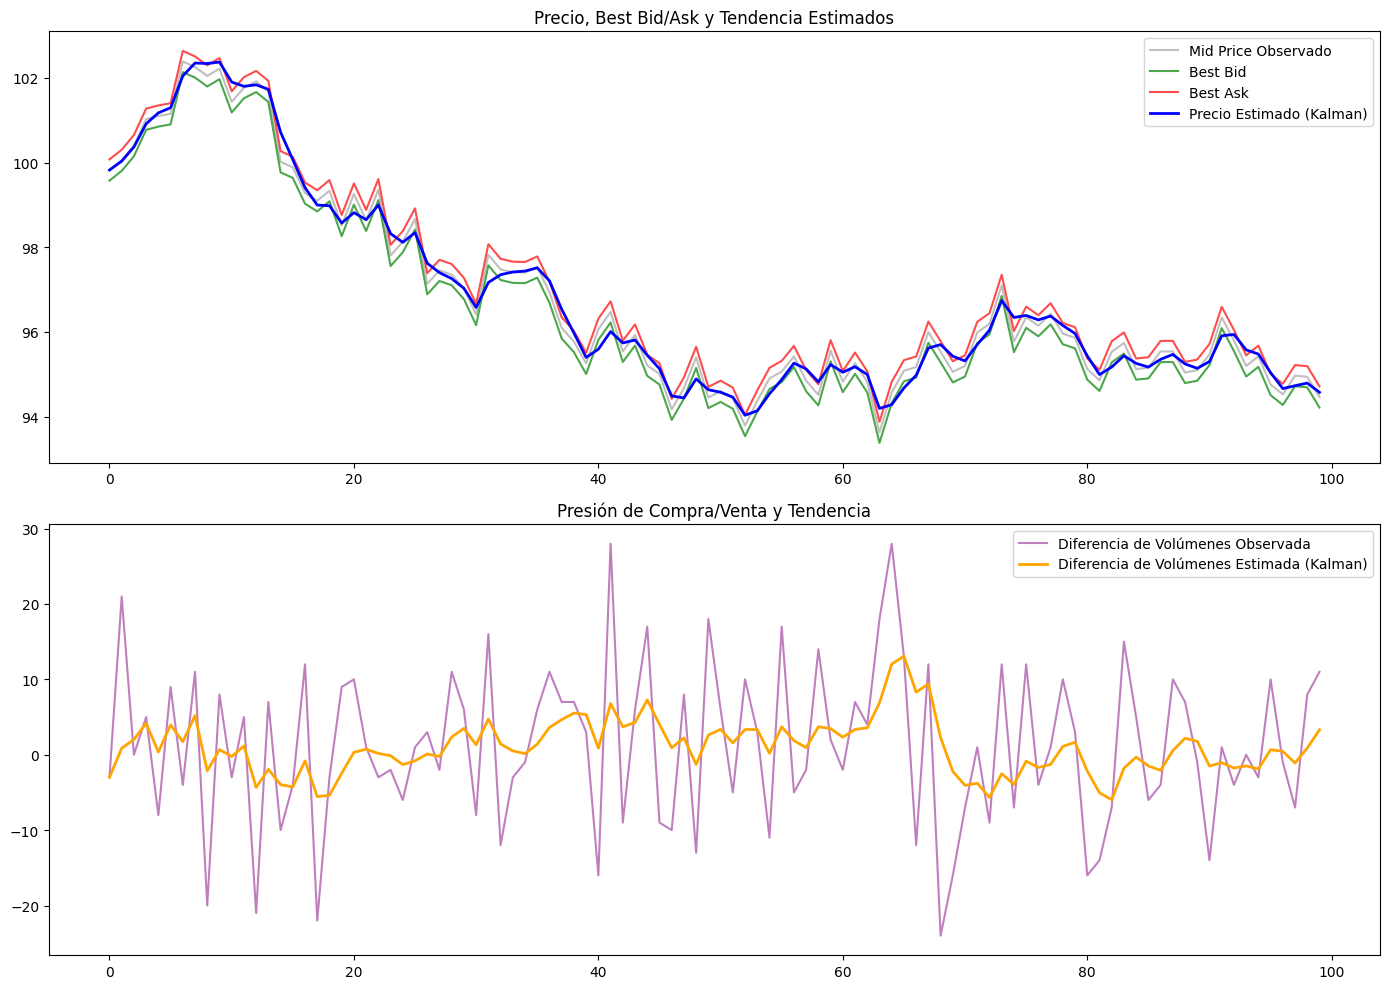

In [6]:
# Aplicar el filtro de Kalman
kf = Kalman(transition_covariance=0.01, observation_covariance=[0.1, 10])
states = kf.fit(df['mid_price'], df['volume_diff'])
# Graficar los resultados
kf.plot_results(df)

In [10]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
from scipy.optimize import minimize

class KalmanMLE:
    def __init__(self, mid_price, volume_diff):
        """
        Inicializa el estimador MLE para el filtro de Kalman.

        Parámetros:
        - mid_price: Serie temporal del mid price.
        - volume_diff: Serie temporal de la diferencia de volúmenes (bid - ask).
        """
        self.mid_price = mid_price.values
        self.volume_diff = volume_diff.values
        self.observations = np.column_stack([mid_price, volume_diff])

        # Matriz de transición (4x4)
        self.transition_matrix = np.array([
            [1, 1, 0, 0],  # p_t = p_{t-1} + v_{t-1}
            [0, 1, 0, 0],  # v_t = v_{t-1}
            [0, 0, 1, 1],  # d_t = d_{t-1} + s_{t-1}
            [0, 0, 0, 1]   # s_t = s_{t-1}
        ])

        # Matriz de observación (2x4)
        self.observation_matrix = np.array([
            [1, 0, 0, 0],  # Observamos p_t
            [0, 0, 1, 0]   # Observamos d_t
        ])

    def log_likelihood(self, params):
        """
        Calcula la log-verosimilitud negativa para los parámetros dados.

        Parámetros:
        - params: Lista con [Q, R_price, R_volume].
        """
        Q, R_price, R_volume = params
        observation_covariance = np.diag([R_price, R_volume])

        # Estado inicial
        initial_state_mean = [self.mid_price[0], 0, self.volume_diff[0], 0]
        initial_state_covariance = np.eye(4)

        # Crear el filtro
        kf = KalmanFilter(
            transition_matrices=self.transition_matrix,
            observation_matrices=self.observation_matrix,
            initial_state_mean=initial_state_mean,
            initial_state_covariance=initial_state_covariance,
            transition_covariance=Q * np.eye(4),
            observation_covariance=observation_covariance
        )

        # Calcular la log-verosimilitud
        log_likelihood_value = kf.loglikelihood(self.observations)
        return -log_likelihood_value  # Minimizamos la log-verosimilitud negativa

    def fit(self):
        """
        Estima los parámetros óptimos (Q, R_price, R_volume) usando MLE.
        """
        # Valores iniciales para Q, R_price, R_volume
        initial_params = [0.01, 0.1, 10]

        # Optimización
        result = minimize(
            self.log_likelihood,
            initial_params,
            method='L-BFGS-B',
            bounds=[(1e-5, 1), (1e-5, 1), (1e-5, 50)]
        )

        # Parámetros optimizados
        self.Q_opt, self.R_price_opt, self.R_volume_opt = result.x
        self.observation_covariance_opt = np.diag([self.R_price_opt, self.R_volume_opt])

        return {
            'Q': self.Q_opt,
            'R_price': self.R_price_opt,
            'R_volume': self.R_volume_opt
        }

    def get_optimal_filter(self):
        """
        Devuelve un filtro de Kalman con los parámetros óptimos estimados.
        """
        initial_state_mean = [self.mid_price[0], 0, self.volume_diff[0], 0]
        initial_state_covariance = np.eye(4)

        optimal_kf = KalmanFilter(
            transition_matrices=self.transition_matrix,
            observation_matrices=self.observation_matrix,
            initial_state_mean=initial_state_mean,
            initial_state_covariance=initial_state_covariance,
            transition_covariance=self.Q_opt * np.eye(4),
            observation_covariance=self.observation_covariance_opt
        )

        return optimal_kf



Parámetros óptimos: Q=0.0085, R_price=0.2020, R_volume=50.0000


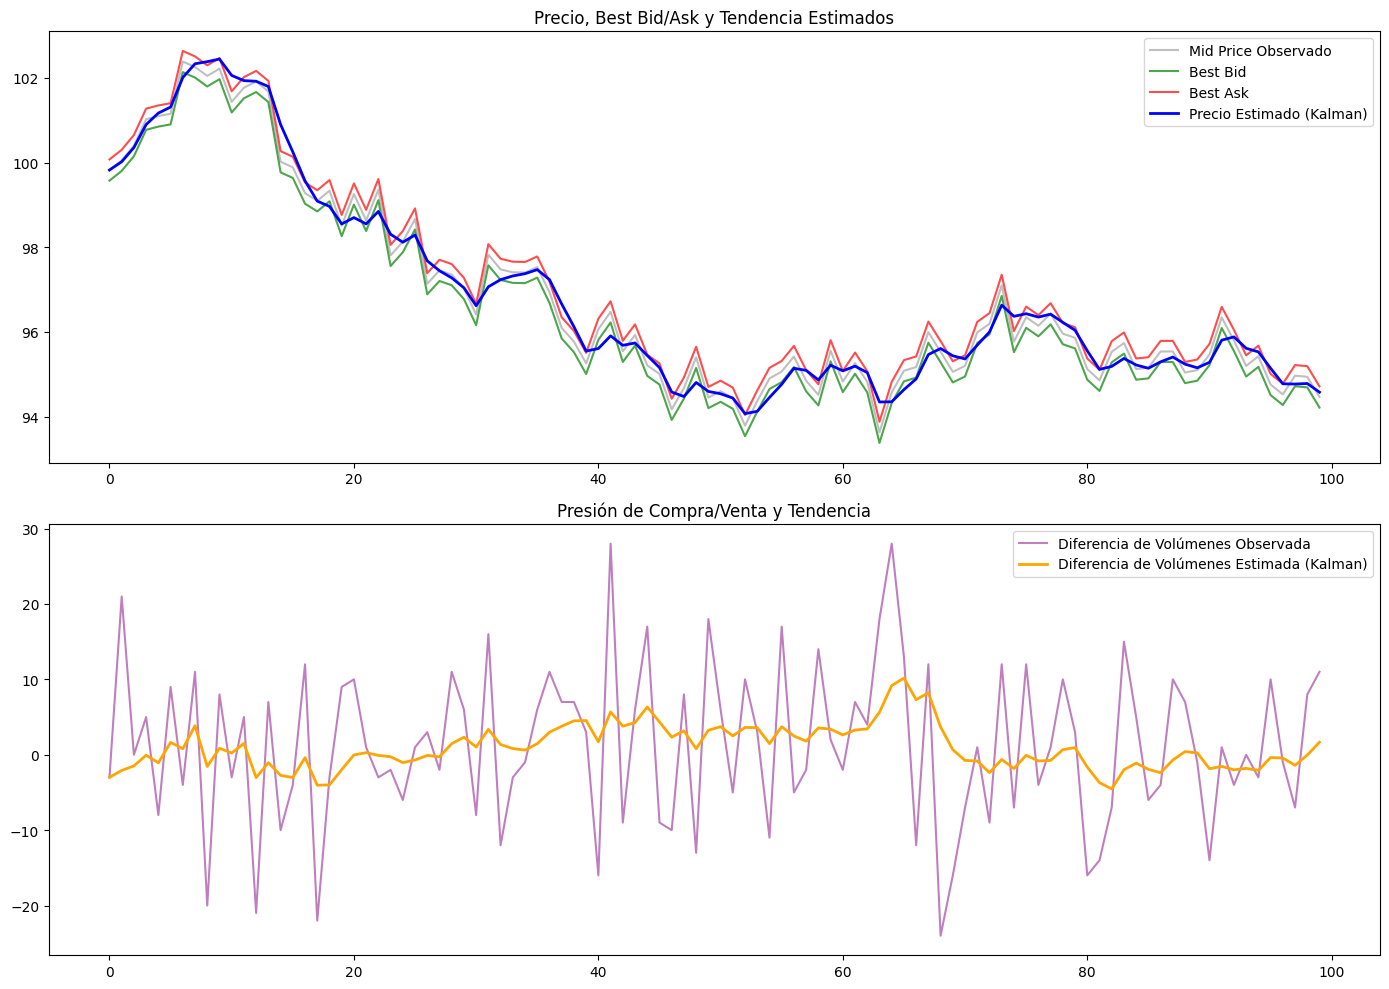

In [11]:
# Estimación de parámetros con MLE
mle_estimator = KalmanMLE(df['mid_price'], df['volume_diff'])
optimal_params = mle_estimator.fit()

print(f"Parámetros óptimos: Q={optimal_params['Q']:.4f}, R_price={optimal_params['R_price']:.4f}, R_volume={optimal_params['R_volume']:.4f}")

# Obtener el filtro óptimo
optimal_kf = mle_estimator.get_optimal_filter()

# Aplicar el filtro óptimo
states, _ = optimal_kf.filter(mle_estimator.observations)

# Guardar resultados en el DataFrame
df['estimated_price'] = states[:, 0]
df['estimated_trend'] = states[:, 1]
df['estimated_volume_diff'] = states[:, 2]
df['estimated_volume_trend'] = states[:, 3]

# Graficar resultados
plt.figure(figsize=(14, 10))

# Gráfica del precio
plt.subplot(2, 1, 1)
plt.plot(df['mid_price'], label='Mid Price Observado', alpha=0.5, color='gray')
plt.plot(df['best_bid'], label='Best Bid', alpha=0.7, color='green')
plt.plot(df['best_ask'], label='Best Ask', alpha=0.7, color='red')
plt.plot(df['estimated_price'], label='Precio Estimado (Kalman)', linewidth=2, color='blue')
plt.legend()
plt.title('Precio, Best Bid/Ask y Tendencia Estimados')

# Gráfica de la diferencia de volúmenes
plt.subplot(2, 1, 2)
plt.plot(df['volume_diff'], label='Diferencia de Volúmenes Observada', alpha=0.5, color='purple')
plt.plot(df['estimated_volume_diff'], label='Diferencia de Volúmenes Estimada (Kalman)', linewidth=2, color='orange')
plt.legend()
plt.title('Presión de Compra/Venta y Tendencia')

plt.tight_layout()
plt.show()
